# **Initializations**

In [1]:
import pickle,gzip,math,os,time,shutil,torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sys,gc,traceback
import fastcore.all as fc
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *

In [2]:
from fastcore.test import test_close

torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

import logging
logging.disable(logging.WARNING)

#set_seed(42)

## **Recreating the Case of Faulty Initializations**

Recall that in the previous NB, `10_activations`,  we were able to use Hooks to visualize the layerwise activations of a simple baseline CNN which uses a `MomentumLearner`. This proved to be a powerful technique to identify and diagnose any issues during the early stages of the training process.

We also established that while the baseline model had improved loss and accuracy metrics when compared to the standard `Learner`, it still began training incorrectly. This could be observed in the poor activation stats for its different layers. 

Let's proceed to recreate the faulty CNN to see how the issue can be fixed.

In [3]:
# Load Data and run inplace transformations
xl, yl = 'image', 'label'
name = "fashion_mnist"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

# Batch size and transforms
bs = 1024
tds = dsd.with_transform(transformi)

In [4]:
# Load the data onto Dataloader and create batches
dls = DataLoaders.from_dd(tds, bs, num_workers=4)
dt = dls.train
xb, yb = next(iter(dt))
xb.shape, yb[:10]

(torch.Size([1024, 1, 28, 28]), tensor([5, 4, 9, 4, 3, 0, 6, 5, 7, 6]))

In [5]:
# Setup model
def get_model():
    return nn.Sequential(conv(1, 8), 
                         conv(8, 16),
                         conv(16, 32),
                         conv(32, 64),
                         conv(64, 10, act=False),
                         nn.Flatten()).to(def_device)

/home/bchaudhry/miniforge3/envs/miniai/lib/python3.11/site-packages/torch/nn/modules/conv.py:459: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995622/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:80.)
  return F.conv2d(input, weight, bias, self.stride,


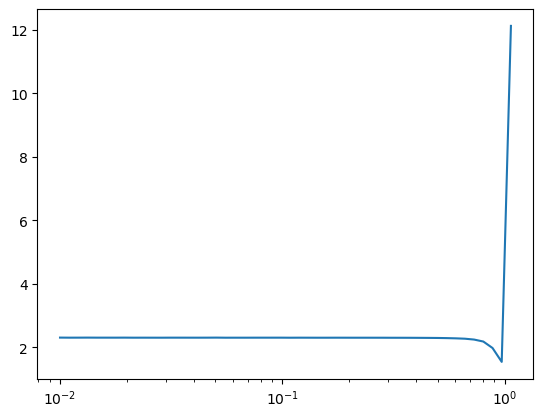

In [6]:
# Find a good learning rate using the LR Finder
MomentumLearner(get_model(), dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find(gamma=1.1, start_lr=1e-2)

In [7]:
# Setup metrics, activation stats, callbacks and learner
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

accuracy,loss,epoch,train
0.317,2.008,0,train
0.652,0.993,0,eval


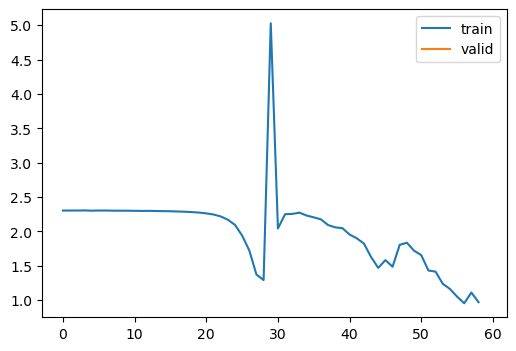

In [8]:
# Fit one epoch
learn.fit(1)

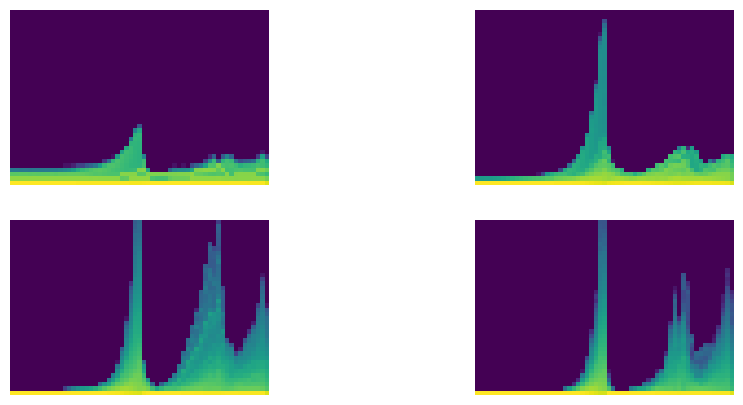

In [9]:
# Activation stats for the model's layers following one epoch of training
astats.color_dim();

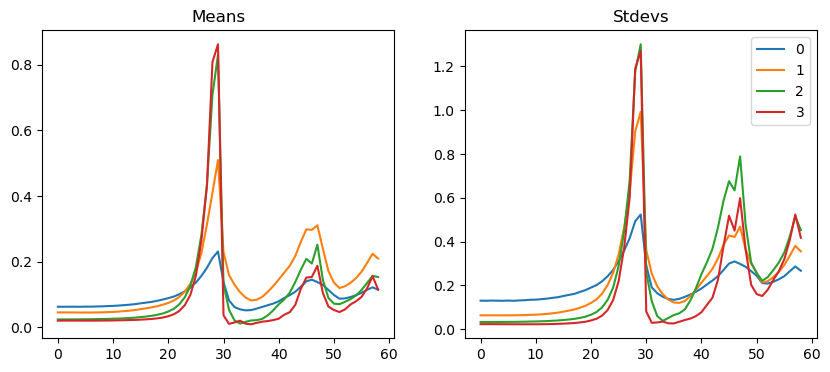

In [10]:
# Means and Standard Deviations of activations
astats.plot_stats();

### **Some Extra Functionality**  

The following functions allow us to clean and recover both GPU and system memory without having to restart the notebook kernel.

`clean_ipython_hist()` is designed to clean the history of commands in an active IPython session.

In [11]:
def clean_ipython_hist():
    # Copied mainly from IPython source
    if not 'get_ipython' in globals(): return
    ip = get_ipython() # Currently running IPython instance
    user_ns = ip.user_ns # Namespace (dictionary) where user variables are stored
    pc = ip.displayhook.prompt_count + 1 # Number of commands/cells executed in the current session 
    # Cycle through inputs in the namespace, and clear the stored input history
    # None ensures no error is raised if a key doesn't exist
    for n in range(1, pc): user_ns.pop('_i' + repr(n), None) 
    # Set the last 3 inputs in the session to empty to clear references
    user_ns.update(dict(_i='', _ii='', _iii=''))
    # hm is the history manager of any given session
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc # Clear parsed input history
    hm.input_hist_raw[:] = [''] * pc # Clear raw input history
    hm._i = hm._ii = hm._iii = hm._i00 = '' # Clear last few inputs from hm.

Next, `clean_tb()` is meant to free up resources and preventing memory leaks after an exception has occurred by clearing the last traceback's frames to free up memory.

In [12]:
def clean_tb():
    if hasattr(sys, 'last_traceback'): # Check for last_traceback attribute in the event of an unhandled exception
        # Remove references to local variables and free up memory
        traceback.clear_frames(sys.last_traceback) 
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type') # Remove last exception's type
    if hasattr(sys, 'last_value'): delattr(sys, 'last_value') # Remove last exception's actual value

In [13]:
# Function to run memory cleaning ops
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

## **Glorot / Xavier Initialization**

This type of initialization came from one of the early papers titled ["Understanding the Difficulty of Training Deep Feedforward Neural Networks"](http://proceedings.mlr.press/v9/glorot10a) which attempted to address the issue of the poor performance of SGD using purely random initializations.

A simple way to understand the mechanics of initializations is to create a matrix (inputs) with random numbers and to carry out a series of matrix multiplications with another matrix (weights) containing random numbers. This basically simulates the creation of a 50 deep neural network.

The output will be `nan`, denoting extremely large numbers.

In [14]:
# randn() ensures mean 0 and variance 1
x = torch.randn(200, 100)
for i in range(50): x = x @ torch.randn(100, 100)
x[0:10, 0:10]

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

Given that the scale of our matrix was too large, we can experiment with decreasing the size of our weights.

This approach creates another problem. With weights being too small, the scale of our activations will go from 1 to 0.1, and after 50 or so layers, the end result is 0s (due to extremely small numbers).

In [15]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100, 100) * 0.01) # Decrease the weights
x[0:10, 0:10]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

The scaling of our weight matrices needs to be just right so that the standard deviation of the activation remains 1 or close to 1, with the mean being 0 or close to 0. Glorot and Bengio used the scale $\frac{1}{\sqrt{n_{in}}}$, with $n_{in}$ being the number of inputs.

In [16]:
x = torch.randn(200, 100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.1)
x[0:10,0:10]

tensor([[-0.07, -0.44, -0.61, -0.16, -0.86, -0.27,  0.25, -0.15, -0.24,  0.47],
        [ 0.20, -1.22, -0.92, -0.70, -0.78, -0.01,  1.26, -0.57, -0.38,  0.68],
        [ 0.56,  0.04,  1.11, -0.23,  1.07,  0.52,  0.36,  0.20,  0.38,  0.05],
        [ 0.24,  0.41, -0.22,  0.18, -0.32, -0.14, -0.20, -0.13,  0.32,  0.52],
        [ 0.22, -0.52, -0.17, -0.30,  0.07,  0.19,  0.62, -0.16, -0.20,  0.16],
        [ 0.20,  0.41,  1.05,  0.14,  1.40,  0.53, -0.35,  0.43,  0.27, -0.73],
        [ 0.46, -0.26,  0.94, -0.46,  0.91,  0.50,  0.53,  0.03,  0.21, -0.00],
        [-0.75, -1.54, -1.35, -0.83, -2.01, -0.51,  0.65, -0.44, -0.47,  0.51],
        [-0.25, -0.33, -0.27, -0.24, -0.72, -0.13,  0.24, -0.11, -0.07,  0.24],
        [ 0.21, -0.30, -0.21, -0.18, -0.32, -0.01,  0.29, -0.01, -0.05,  0.52]])

### **Derivation**

When we do `y = a @ x`, the coefficients of `y` are defined by

$$y_{i} = a_{i,0} x_{0} + a_{i,1} x_{1} + \cdots + a_{i,n-1} x_{n-1} = \sum_{k=0}^{n-1} a_{i,k} x_{k}$$

or in pure python code:
```
y[i] = sum([c*d for c,d in zip(a[i], x)])
```

or in numpy/pytorch code:
```
y[i] = (a[i]*x).sum()
```

At the very beginning, our `x` vector has a mean of roughly 0. and a standard deviation of roughly 1. (since that was the requirement).

In [17]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.07), tensor(0.91))

Assuming that we choose weights for `a` which also have a mean of 0, the standard deviation of `y` can be computed easily. The matmul operation is repeated many times to offset the chance of ending up with erroneous values.

In [18]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()

mean / 100, sqr / 100

(0.04130381405353546, 99.83621391296387)

The result is very close to the random matrix in the with 100 elements. This demonstrates that as long as the elements in `a` and the elements in `x` are independent, the mean stays close to 0 and the standard deviatin stays close to 1.

In [19]:
mean, sqr = 0., 0.
for i in range(100000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a*x
    mean += y.item()
    sqr  += y.pow(2).item()

mean / 100000, sqr / 100000

(-0.0024864671496836015, 1.0014610323837898)

> Then we sum 100 of those things that have a mean of zero, and a mean of squares of 1, so we get something that has a mean of 0, and mean of square of 100, hence math.sqrt(100) being our magic number. If we scale the weights of the matrix and divide them by this math.sqrt(100), it will give us a y of scale 1, and repeating the product has many times as we want won't overflow or vanish.

Mathematically, that all seems fine. But the Xavier / Glorot Initialization **doesn't work when rectified linear units are added to the mix**.

## **Kaiming / He Initialization**

### **Derivation**

In [33]:
x = torch.randn(200, 100)
y = torch.randn(200)

x.shape, y.shape

(torch.Size([200, 100]), torch.Size([200]))

In [34]:
from math import sqrt

In [35]:
# Initialize random weights and biases
w1 = torch.randn(100, 50) / sqrt(100) # Sqrt 100 is specifically mentioned in the Glorot paper.
b1 = torch.zeros(50)
w2 = torch.randn(50, 1) / sqrt(50)
b2 = torch.zeros(1)

In [36]:
# Function to create a simple linear model
def lin(x, w, b): return x @ w + b

In [37]:
# Layer 1 of the model's forward pass
l1 = lin(x, w1, b1)
l1.mean(), l1.std()

(tensor(-0.01), tensor(1.00))

In [38]:
# Function to create ReLU layer
def relu(x): return x.clamp_min(0.)

# Running outputs of layer 1 through RelU
l2 = relu(l1)
l2.mean(), l2.std()

(tensor(0.39), tensor(0.59))

During the forward pass, the outputs of the linear layer - having a mean close to 0 and standard deviation close to 1 - were passsed through a ReLU layer. This resulted in the mean and standard deviation which moved away from 0 and 1 quite measurably.

When we do the same for our simulated neural network i.e. pass it through a ReLU layer while using the Glorot / Xavier initialization, the result is a matrix full of zeros or extremely small numbers.

In [39]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * 0.1))
x[0:10, 0:10]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00,     0.00],
        [ 

The fix for this problem came with the highly impactful paper titled "Delving Deep into Rectifiers: Surpassing Human-Level Performance". Here Kaiming He et al. showed that we should be using a scaling factor of $\sqrt{2 / n_{in}}$.

In [58]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100, 100) * sqrt(2/100)))
x[0:10, 0:10]

tensor([[0.00, 0.00, 0.00, 0.58, 0.00, 0.00, 0.00, 0.00, 0.46, 0.42],
        [0.00, 0.00, 0.00, 1.20, 0.00, 0.00, 0.00, 0.00, 0.99, 0.91],
        [0.00, 0.00, 0.00, 0.65, 0.00, 0.00, 0.00, 0.00, 0.55, 0.44],
        [0.00, 0.00, 0.00, 1.23, 0.00, 0.00, 0.00, 0.00, 0.93, 0.81],
        [0.00, 0.00, 0.00, 0.55, 0.00, 0.00, 0.00, 0.00, 0.41, 0.35],
        [0.00, 0.00, 0.00, 0.78, 0.00, 0.00, 0.00, 0.00, 0.58, 0.49],
        [0.00, 0.00, 0.00, 0.77, 0.00, 0.00, 0.00, 0.00, 0.63, 0.51],
        [0.00, 0.00, 0.00, 1.01, 0.00, 0.00, 0.00, 0.00, 0.84, 0.79],
        [0.00, 0.00, 0.00, 0.80, 0.00, 0.00, 0.00, 0.00, 0.64, 0.54],
        [0.00, 0.00, 0.00, 1.23, 0.00, 0.00, 0.00, 0.00, 0.98, 0.91]])

This results in a lot more activations!

## **Applying An Initialization Function**

In [59]:
# Create model and print out all the modules
model = get_model()
# Print all modules regardless of their depth
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


In [60]:
# Applying PyTorch's Kaiming initialization
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d)): init.kaiming_normal_(m.weight)

In [61]:
# Apply the function recursively to every module
model.apply(init_weights);

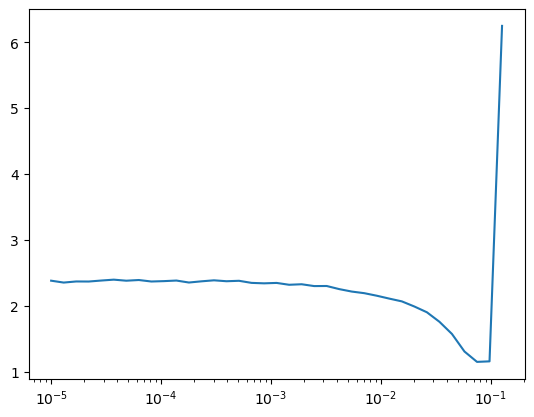

In [62]:
MomentumLearner(model, dls, F.cross_entropy, cbs=[DeviceCB()]).lr_find()

accuracy,loss,epoch,train
0.607,1.169,0,train
0.786,0.568,0,eval
0.823,0.474,1,train
0.834,0.450,1,eval
0.850,0.402,2,train
0.848,0.414,2,eval


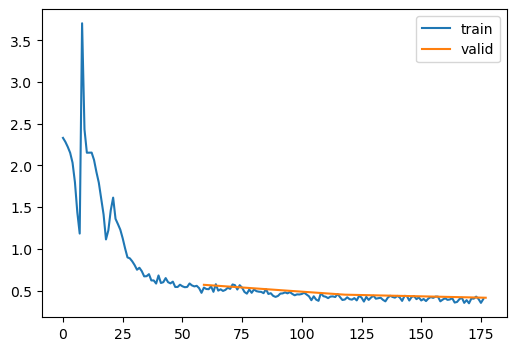

In [63]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.2, cbs=cbs)

learn.fit(3)

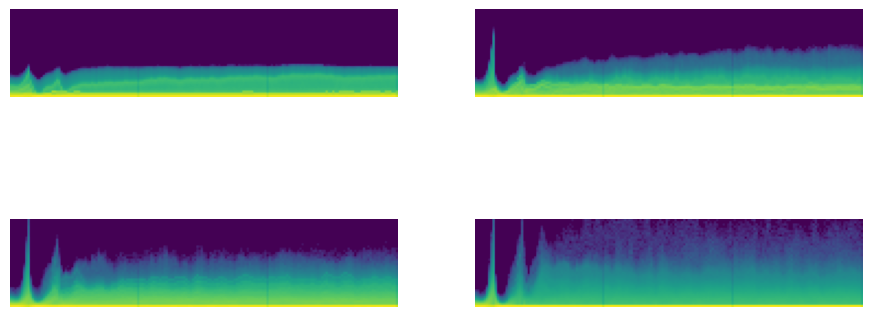

In [64]:
astats.color_dim()

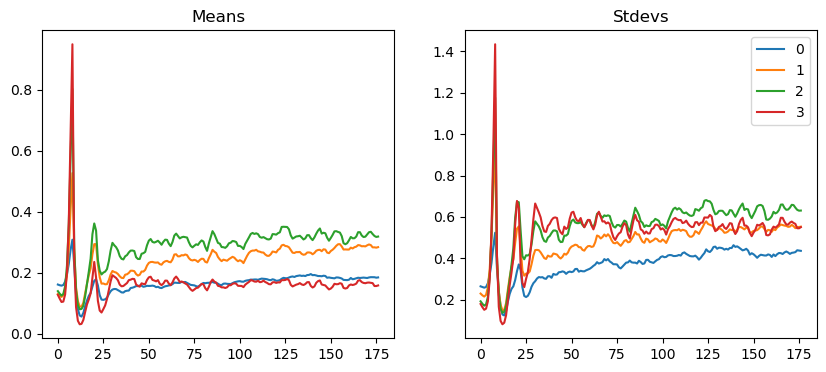

In [65]:
astats.plot_stats()

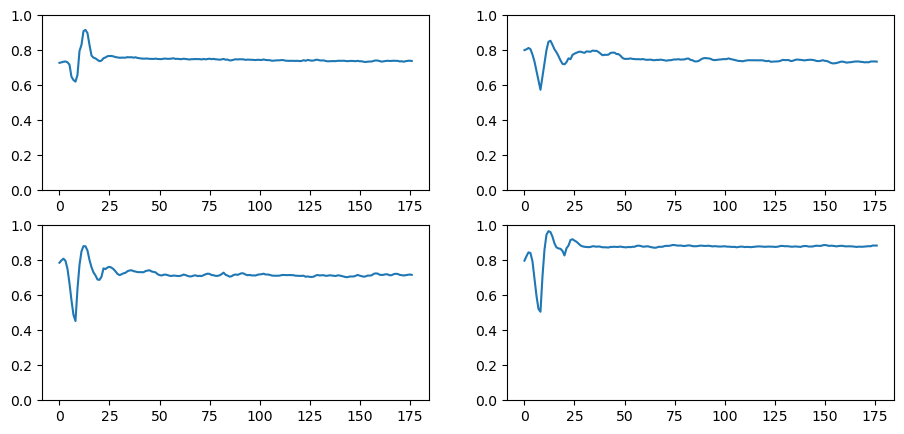

In [66]:
astats.dead_chart()

While the model's training run isn't ideal by any stretch, given the spikes in early steps, the plots show that activations per layer have vastly increased. But the issue of not having a mean of 0 and standard deviation of 1 remains!!